In [ ]:
import pandas as pd 

df_eng = pd.read_csv("english_essays.csv")


,essay_id,score,full_text,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,source_text_1,source_text_2,source_text_3,source_text_4
0,AAAVUP14319000159574,4,The author suggests that studying Venus is wor...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,Black/African American,F,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN
1,AAAVUP14319000159542,2,NASA is fighting to be alble to to go to Venus...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN
2,AAAVUP14319000159461,3,"""The Evening Star"", is one of the brightest po...","In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,White,M,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN
3,AAAVUP14319000159420,2,The author supports this idea because from rea...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,F,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN
4,AAAVUP14319000159419,2,How the author supports this idea is that he s...,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,M,"The Challenge of Exploring Venus\nVenus, somet...",NaN,NaN,NaN


In [ ]:
df_eng = df_eng[["score", "full_text"]].dropna()
df_eng.columns = ['essay', 'score']


In [ ]:
df_eng = df_eng[['score', 'essay']]


,score,essay
0,The author suggests that studying Venus is wor...,4
1,NASA is fighting to be alble to to go to Venus...,2
2,"""The Evening Star"", is one of the brightest po...",3
3,The author supports this idea because from rea...,2
4,How the author supports this idea is that he s...,2
...,...,...
24723,"Hello, my name is STUDENT_NAME. I think driver...",2
24724,What you are about to read is going to give yo...,3
24725,umm yeah just dont drive as much you can save ...,1
24726,if we look back at time in the united states y...,2


In [13]:
def load_europarl_file(file_path, max_lines=5000):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f.readlines()[:max_lines]]
    return lines

german_texts = load_europarl_file("europarl-v7.de-en.de")
spanish_texts = load_europarl_file("europarl-v7.es-en.es")
french_texts = load_europarl_file("europarl-v7.fr-en.fr")


In [14]:
def create_documents(sentences, doc_len=10):
    return [" ".join(sentences[i:i+doc_len]) for i in range(0, len(sentences) - doc_len, doc_len)]

german_docs = create_documents(german_texts)
spanish_docs = create_documents(spanish_texts)
french_docs = create_documents(french_texts)


In [22]:
import numpy as np
import random

def assign_fake_scores(documents):
    return [random.randint(2, 6) for _ in documents]  # Or use a heuristic

german_scores = assign_fake_scores(german_docs)
spanish_scores = assign_fake_scores(spanish_docs)
french_scores = assign_fake_scores(french_docs)


In [25]:
df_de = pd.DataFrame({'essay': german_docs, 'score': german_scores, 'lang': 'de'})
df_es = pd.DataFrame({'essay': spanish_docs, 'score': spanish_scores, 'lang': 'es'})
df_fr = pd.DataFrame({'essay': french_docs, 'score': french_scores, 'lang': 'fr'})

full_df = pd.concat([df_eng, df_de, df_es, df_fr], ignore_index=True)


In [27]:
!pip install pandas numpy scikit-learn tensorflow


  Obtaining dependency information for gast<=0.4.0,>=0.2.1 from https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for jax>=0.3.15 from https://files.pythonhosted.org/packages/86/bb/fdc6513a9aada13fd21e9860e2adee5f6eea2b4f0a145b219288875acb26/jax-0.5.3-py3-none-any.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/b8/d0/e6a2cb9a3f3e863a43e50949e9ae704be70baf398fd5af59355f65c8740a/numpy-1.23.5-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3 from https://files.pythonhosted.org/packages/b7/03/361e87cc824452376c2abcef0eabd18da78a7439479ec6541cf29076a4dc/protobuf-4.25.6-cp37-abi3-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for tensorboard<2.13,>=2.12 from https://files.pyth

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 20000    # Max number of unique words to keep
MAX_SEQ_LENGTH = 500     # Max length of each input (in tokens)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(full_df['essay'].values)   # Learn vocabulary

sequences = tokenizer.texts_to_sequences(full_df['essay'].values)  # Convert each text to a list of integers
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')  # Pad to fixed length


In [31]:
y = full_df['score'].values


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQ_LENGTH),
    Conv1D(128, 5, activation='relu'),  # 128 filters, 5-word kernel
    GlobalMaxPooling1D(),               # Collapse time dimension
    Dense(64, activation='relu'),       # Fully connected layer
    Dropout(0.5),                       # Regularization
    Dense(1, activation='linear')       # Output: 1 value (score)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          2560000   
                                                                 
 conv1d (Conv1D)             (None, 496, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [33]:
from sklearn.model_selection import train_test_split

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Epoch 1/10


2025-04-05 22:44:22.677018: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


656/656 [==============================] - 28s 42ms/step - loss: 1.3136 - mae: 0.8820 - val_loss: 0.5698 - val_mae: 0.5865
Epoch 2/10
656/656 [==============================] - 28s 42ms/step - loss: 0.8200 - mae: 0.7049 - val_loss: 0.5353 - val_mae: 0.5684
Epoch 3/10
656/656 [==============================] - 27s 41ms/step - loss: 0.6569 - mae: 0.6310 - val_loss: 0.5143 - val_mae: 0.5479
Epoch 4/10
656/656 [==============================] - 28s 43ms/step - loss: 0.5042 - mae: 0.5516 - val_loss: 0.5243 - val_mae: 0.5509
Epoch 5/10
656/656 [==============================] - 28s 43ms/step - loss: 0.4068 - mae: 0.4932 - val_loss: 0.5368 - val_mae: 0.5612
Epoch 6/10
656/656 [==============================] - 28s 43ms/step - loss: 0.3467 - mae: 0.4518 - val_loss: 0.5495 - val_mae: 0.5734
Epoch 7/10
656/656 [==============================] - 28s 43ms/step - loss: 0.3063 - mae: 0.4206 - val_loss: 0.6250 - val_mae: 0.6197
Epoch 8/10
656/656 [==============================] - 28s 43ms/step - los

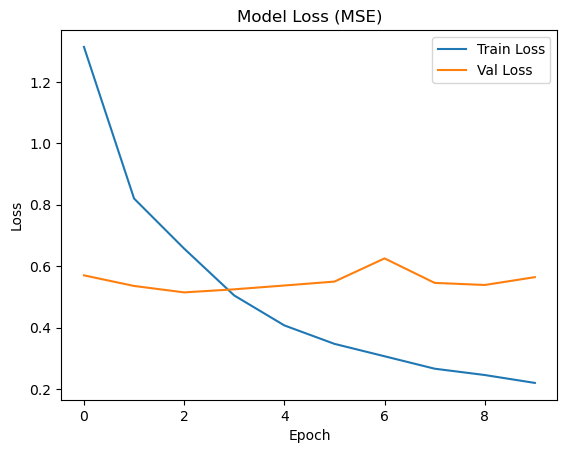

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


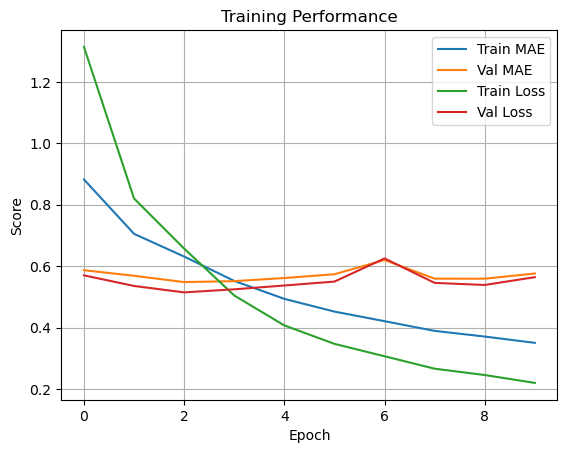

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
y_pred = model.predict(X_val).flatten()

# Compare actual vs predicted
import numpy as np

for i in range(5):
    print(f"Predicted: {round(y_pred[i], 2)}, Actual: {y_val[i]}")


164/164 [==============================] - 2s 9ms/step
Predicted: 3.190000057220459, Actual: 4
Predicted: 2.6500000953674316, Actual: 2
Predicted: 3.319999933242798, Actual: 4
Predicted: 2.4800000190734863, Actual: 3
Predicted: 4.559999942779541, Actual: 4


In [37]:
rounded_preds = np.round(y_pred)
accuracy = np.mean(rounded_preds == y_val)
print(f"Exact match accuracy: {accuracy:.2%}")

Exact match accuracy: 53.57%


In [38]:
within_1 = np.mean(np.abs(rounded_preds - y_val) <= 1)
print(f"Accuracy within ±1 point: {within_1:.2%}")


Accuracy within ±1 point: 95.48%
